# Diffusion Model Project

In [4]:
from functions import *

In [5]:
import torch
import diffusers
from PIL import Image
from tqdm import tqdm
import os

/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# setup
model_id = "google/ddpm-bedroom-256" # "google/ddpm-celebahq-256"
model = diffusers.UNet2DModel.from_pretrained(model_id)
ddpm_scheduler = diffusers.DDPMScheduler.from_pretrained(model_id)
ddpm_scheduler.set_timesteps(50)

An error occurred while trying to fetch google/ddpm-bedroom-256: google/ddpm-bedroom-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Denoising Animation

In [7]:
# input prepraration
image_size = model.config.sample_size # get image size
noise = torch.randn((1, 3, image_size, image_size)) # sample random noise

,,
Image,Predicted Noise,Image - Predicted Noise
,50/50,

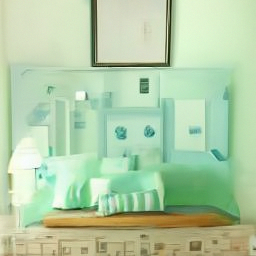
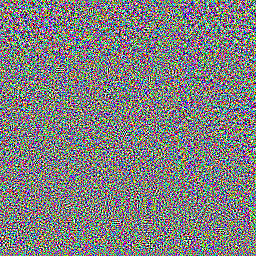
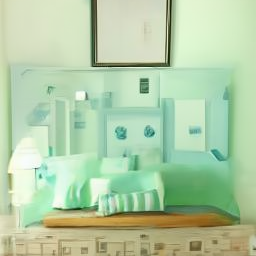

In [8]:
# output generation
current = noise
history = [noise]
for i, t in enumerate(ddpm_scheduler.timesteps):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = ddpm_scheduler.step(predicted_noise, t, current).prev_sample
        show_table([[tensor_as_html(history[-1]), tensor_as_html(predicted_noise), tensor_as_html(current)], ["Image", "Predicted Noise", "Image - Predicted Noise"], ["", f"{i + 1}/50", ""]])
        history.append(current)

,,,,,

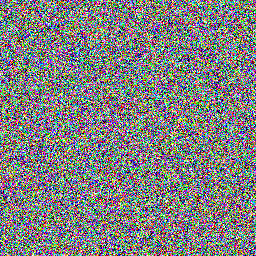
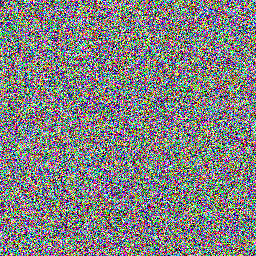
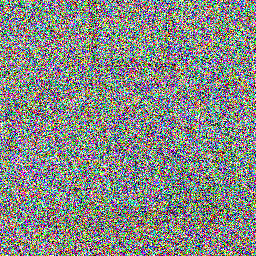
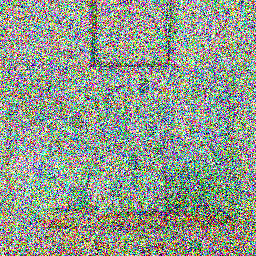
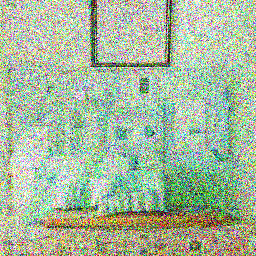
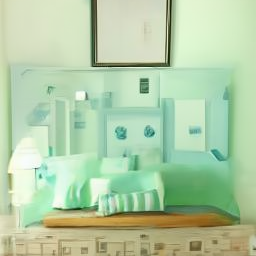

In [12]:
# show images
show_images(*history[::10])

In [7]:
# save image
os.makedirs("../output", exist_ok=True)
tensor_as_image(current).save("../output/output.png")

# Forward and Backward Process

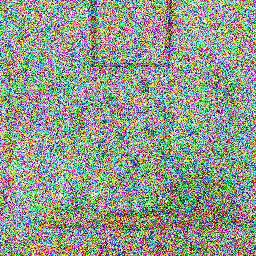

In [15]:
# forward process
noised_image = ddpm_scheduler.add_noise(current, noise, ddpm_scheduler.timesteps[30])
tensor_as_image(noised_image)

""

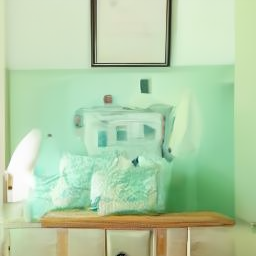

100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


In [16]:
# backward process
current = noised_image
for t in tqdm(ddpm_scheduler.timesteps[30:]):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = ddpm_scheduler.step(predicted_noise, t, current).prev_sample
        show_images(current)

,,

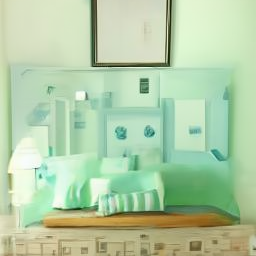
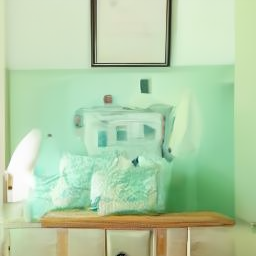
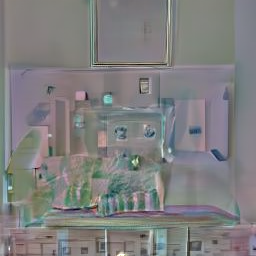

In [17]:
# compare images
show_images(history[-1], current, history[-1] - current)

In [ ]:
# create forward / backward process image
image = current # image_as_tensor(Image.open("../output/ddpm_9.png"))

# setup output image
output = Image.new("RGB", (image_size * 50, image_size * 50), (255, 255, 255))
output.paste(tensor_as_image(image), (0, 0))

# output generation
with tqdm(total=sum(range(1, 51))) as tqdm_bar:
    for i in reversed(range(50)):
        current = ddpm_scheduler.add_noise(image, noise, ddpm_scheduler.timesteps[i])
        output.paste(tensor_as_image(current), (0, image_size * (50 - i)))
        for j, t in enumerate(ddpm_scheduler.timesteps[i:]):
            with torch.no_grad():
                predicted_noise = model(current, t).sample
                current = ddpm_scheduler.step(predicted_noise, t, current).prev_sample
                output.paste(tensor_as_image(current), (image_size * (j + 1), image_size * (50 - i)))
            tqdm_bar.update(1)

# save output image
output.save("output/process.png")

# Noise Patch DDIM

In [18]:
# setup
ddim_scheduler = diffusers.DDIMScheduler.from_pretrained(model_id)
ddim_scheduler.set_timesteps(50)

,

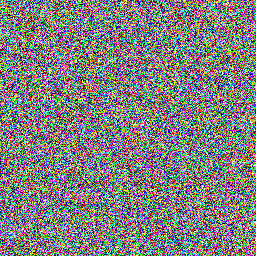
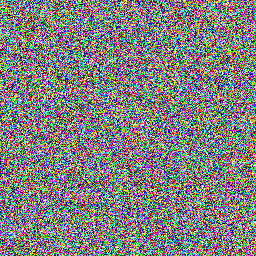

In [19]:
# prepare input
noise = torch.randn((1, 3, image_size, image_size)) # sample random noise
noises = [noise.clone() for _ in range(2)] # duplicate noise
noises[1][:,:,50:100,50:100] = torch.randn((1, 3, 50, 50)) # modify second noise
show_images(*noises)

""

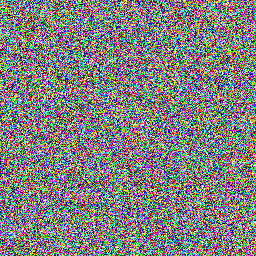

In [20]:
from time import sleep
for i in range(10):
    show_images(noises[i % 2])
    sleep(0.5)

In [21]:
# output generation
images = list()
for current in noises:
    for t in tqdm(ddim_scheduler.timesteps):
        with torch.no_grad():
            predicted_noise = model(current, t).sample
            current = ddim_scheduler.step(predicted_noise, t, current).prev_sample
    images.append(current)

100%|██████████| 50/50 [02:24<00:00,  2.89s/it]


,

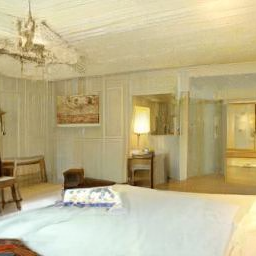
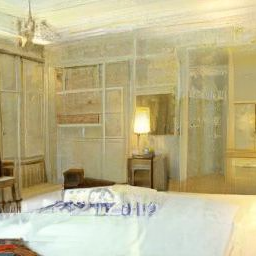

In [22]:
# show output
show_images(*images)

In [32]:
# save input and output
for i in range(len(noises)):
    tensor_as_image(noises[i]).save(f"../output/similar_ddim_noise_{i}.png")
    tensor_as_image(images[i]).save(f"../output/similar_ddim_image_{i}.png")